尝试利用xgboost对青岛房价进行预测

In [20]:
import requests,time,re,csv
from bs4 import BeautifulSoup as BS
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

数据爬取

In [2]:
def request_url(url,headers):
    '''
    访问网页,返回解析的网页代码
    '''
    try:
        resp = requests.get(url,headers=headers)
        soup = BS(resp.text, 'lxml')
        if resp.status_code==200: 
            return soup
    except requests.RequestException:
        return None

In [3]:
def get_position_url(soup_position_url):
    '''
    获取该城市各地区链接,并返回连接列表
    '''
    position_url_list = []
    tags = soup_position_url.find('div',class_="position").find_all('a')
    position_url_list = ['https://qd.lianjia.com'+i['href'] for i in tags[1:]]
    return position_url_list

In [4]:
def get_position_name(soup_position_url):
    '''
    获取该城市地区名称
    '''
    position_name_list = []
    tags = soup_position_url.find('div',class_="position").find_all('a')
    position_name_list = [i['title'][2:4]+'区' for i in tags[1:]]
    return position_name_list
    

In [5]:
def get_urlist(soup):
    '''
    获取该地区每页的商品链接
    '''
    tags = soup.find('ul',class_="listContent").find_all('a',class_="img")
    urlist = [i['href'] for i in tags]
    return urlist

In [6]:
def get_house(soup):
    '''
    获取房源信息
    '''
    # 楼盘名称,成交价,成交单价,成交周期,位置
    house = [] 
    house_code = [
        r"""soup.find('div',class_="wrapper").text.split(' ')[0]""", 
        r"""soup.find('div',class_="price").find('i').text""",
        r"""soup.find('div',class_="price").find('b').text""",
        r"""soup.find('div',class_='msg').find_all('span')[1].text""",
        r"""soup.find('div',class_="deal-bread").find_all('a')[3].text""",
    ]
    for i in house_code:
        try:
            house.append(eval(i))
        except Exception as e:
            house.append(np.nan)
            print('house1 '+str(i)+' got wrong，请检查网址:'+soup.find('link',rel='canonical')['href']) #用于检查网址  
    house1 = [] 
    # 房屋户型,所在楼层,建筑面积
    for i in range(3):
        try:
            house1.append(soup.find('div',class_="newwrap baseinform").find_all('li')[i].text[4:].strip())
        except Exception as e:
            house1.append(np.nan)
    #房屋朝向,建成年代,装修情况,建筑结构,供暖方式,梯户比例,产权年限,配备电梯,链家编号
    for i in range(6,15):
        try:
            house1.append(soup.find('div',class_="newwrap baseinform").find_all('li')[i].text[4:].strip())
        except Exception as e:
            house1.append(np.nan)    
    info = [*house,*house1]
    return info


In [7]:
def data_write(data,columns):
    times = time.strftime("%Y-%m-%d", time.localtime())     
    with open(times+'all_data.csv','a+',newline='') as f:
        writer = csv.writer(f)   
        #writer.writerow(columns)
        for row in data:
            writer.writerow(row)

In [8]:
def main(url,headers,start_page,end_page,columns):
    '''
    start_page:起始页
    end_page:结束页
    columns:特征列表
    '''
    # 网址列表
    list_all_url = []
    for n in range(start_page,end_page+1):
        soup_url = request_url(url+str(n)+'/',headers)#解析单页网址
        if soup_url != None:#判断请求网页是否成功
            houses_urlist = get_urlist(soup_url)#获取所有房源信息网址列表
            list_all_url.extend(houses_urlist)
        else:
            missed1.append(url+str(n)+'/') #存放失败的网址
            continue
    # 解析网址列表
    data_all = []
    missed2 = []
    for u in list_all_url:
        soup_house = request_url(u,headers)
        if soup_house != None:#请求网页成功则获取房源信息,失败则加入失败的网址
            house_info = get_house(soup_house)
            data_all.append(house_info)
        else:
            missed2.append(u)
            continue
    # 写入数据
    data_write(data_all,columns)


In [9]:
#链家青岛页面
url = 'https://qd.lianjia.com/chengjiao/'
headers = { 'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36'}
#获取解析后的链接
soup_position_url = request_url(url,headers)
#获取该城市各地区链接
position_url = get_position_url(soup_position_url)
#获取该城市各地区名称
position_name = get_position_name(soup_position_url)
columns = ['楼盘名称','成交价','成交单价','成交周期','位置','房屋户型','所在楼层','建筑面积'
        ,'房屋朝向','建成年代','装修情况','建筑结构','供暖方式','梯户比例','产权年限','配备电梯','链家编号']
times=time.strftime("%Y-%m-%d", time.localtime())
#将特征作为列名写入文件
with open(times+'all_data.csv','a+',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(columns)
print('开始爬取青岛市各地区二手房成交信息')
for url,name in zip(position_url,position_name):
    print('正在进行%s数据爬取'% name)
    main(url,headers,1,40,columns)
    print('%s数据爬取已完成' % name)
print('青岛市各地区数据爬取已完成')
        

开始爬取青岛市各地区二手房成交信息
正在进行市南区数据爬取
市南区数据爬取已完成
正在进行市北区数据爬取
市北区数据爬取已完成
正在进行李沧区数据爬取
李沧区数据爬取已完成
正在进行崂山区数据爬取
崂山区数据爬取已完成
正在进行黄岛区数据爬取
黄岛区数据爬取已完成
正在进行城阳区数据爬取
城阳区数据爬取已完成
正在进行胶州区数据爬取
胶州区数据爬取已完成
正在进行即墨区数据爬取
即墨区数据爬取已完成
正在进行平度区数据爬取
平度区数据爬取已完成
正在进行莱西区数据爬取
莱西区数据爬取已完成
青岛市各地区数据爬取已完成


数据清洗,预处理

In [21]:
# 载入数据,查看空值等
path ='2019-10-31all_data.csv'
df = pd.read_csv(path,encoding='gbk')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 17 columns):
楼盘名称    9720 non-null object
成交价     9720 non-null int64
成交单价    9720 non-null int64
成交周期    9720 non-null object
位置      9720 non-null object
房屋户型    9720 non-null object
所在楼层    9720 non-null object
建筑面积    9720 non-null object
房屋朝向    9720 non-null object
建成年代    9720 non-null object
装修情况    9720 non-null object
建筑结构    9720 non-null object
供暖方式    9720 non-null object
梯户比例    9720 non-null object
产权年限    9720 non-null object
配备电梯    9720 non-null object
链家编号    9720 non-null int64
dtypes: int64(3), object(14)
memory usage: 1.3+ MB
None


,楼盘名称,成交价,成交单价,成交周期,位置,房屋户型,所在楼层,建筑面积,房屋朝向,建成年代,装修情况,建筑结构,供暖方式,梯户比例,产权年限,配备电梯,链家编号
0,天山小区（宁国路）,175,25736,2成交周期（天）,天山银海二手房成交,2室1厅1厨1卫,高楼层(共6层),68㎡,南,1996,其他,砖混结构,集中供暖,一梯两户,70年,无,103106513612
1,大学路公寓,800,56530,339成交周期（天）,大学路二手房成交,3室2厅1厨2卫,中楼层(共8层),141.52㎡,南,2000,精装,混合结构,集中供暖,一梯两户,70年,无,103103356463
2,华润中心悦府,677,47496,317成交周期（天）,湛山二手房成交,3室2厅1厨2卫,低楼层(共30层),142.54㎡,南 北,2014,精装,钢混结构,集中供暖,两梯三户,70年,有,103103494849
3,闽江路11号,130,24739,88成交周期（天）,新贵都二手房成交,2室0厅1厨1卫,高楼层(共7层),52.55㎡,南 北,1984,简装,混合结构,集中供暖,一梯两户,70年,无,103105408584
4,东海一路,460,44223,25成交周期（天）,湛山二手房成交,3室2厅1厨2卫,低楼层(共6层),104.02㎡,南 北,1994,精装,砖混结构,集中供暖,一梯两户,70年,无,103106149567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,厚德花苑,30,4244,2成交周期（天）,莱西二手房成交,2室1厅1厨1卫,中楼层(共7层),70.69㎡,南 北,2012,其他,未知结构,暂无数据,一梯两户,70年,暂无数据,103104634988
9716,厚德花苑,35,4406,2成交周期（天）,莱西二手房成交,2室1厅1厨1卫,低楼层(共6层),79㎡,南 北,2012,其他,未知结构,暂无数据,一梯两户,70年,暂无数据,103104678086
9717,厚德花苑,30,4244,2成交周期（天）,莱西二手房成交,2室1厅1厨1卫,中楼层(共7层),70.69㎡,南 北,2012,其他,未知结构,暂无数据,一梯两户,70年,暂无数据,103104634988
9718,厚德花苑,35,4406,2成交周期（天）,莱西二手房成交,2室1厅1厨1卫,低楼层(共6层),79㎡,南 北,2012,其他,未知结构,暂无数据,一梯两户,70年,暂无数据,103104678086


In [22]:
# 删除无用列,以及替换空值
df1 = df.copy().drop(['链家编号','供暖方式','配备电梯'],axis=1)
df1.replace('暂无数据',np.nan,inplace=True)

#取消科学技术法,并保留两位小数
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#统一单价为万,与成交价一致,但是价格会出现以科学计数法显示
df1.成交单价 = df1.成交单价/ 10000
#将部分特征取数值部分
df1.建筑面积 = df1.建筑面积.str.replace('㎡', '')
df1.rename(columns={'建筑面积':'建筑面积(㎡)'},inplace=True)

df1.产权年限=df1.产权年限.str.replace('年','')
df1.rename(columns={'产权年限':'产权年限(年)'},inplace=True)

#提取楼层数与所在楼层
df1.所在楼层 = df.所在楼层.str.split("\楼层",expand=True)[0]
df1 = df1.join(df.所在楼层.str.split("\(共",expand=True)[1].str.replace('层\)',''))
df1.rename(columns={1:'总楼层数'},inplace=True)
df1.成交周期=df1.成交周期.str.split("\成交",expand=True)[0]
df1.rename(columns={'成交周期':'成交周期(天)'},inplace=True)

In [23]:
#将数据转为数值型
df1[['成交周期(天)','建筑面积(㎡)','建成年代','产权年限(年)','总楼层数']] = df1[['成交周期(天)','建筑面积(㎡)','建成年代','产权年限(年)','总楼层数']].apply(pd.to_numeric, errors='coerce')

In [24]:
# 将房间数量提取出来,并加入到原来的
room_num = df1.房屋户型.str.extract('(?P<室>\d+)室(?P<厅>\d+)厅(?P<厨>\d+)厨(?P<卫>\d+)卫').astype(np.int8)
df1=pd.merge(df1,room_num,how='left',left_index=True,right_index=True).drop('房屋户型',axis=1)

In [25]:
df1.describe()

,成交价,成交单价,成交周期(天),建筑面积(㎡),建成年代,产权年限(年),总楼层数,室,厅,厨,卫
count,9720.00,9720.00,9720.00,9720.00,8760.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00
mean,170.71,1.83,120.76,91.48,2007.09,66.09,14.55,2.19,1.37,1.01,1.17
std,115.58,0.83,126.61,30.14,7.21,8.31,9.85,0.67,0.54,0.09,0.40
min,14.00,0.26,1.00,35.11,1981.00,40.00,1.00,1.00,0.00,1.00,1.00
25%,108.00,1.23,31.00,72.00,2003.00,70.00,6.00,2.00,1.00,1.00,1.00
50%,140.00,1.66,77.00,87.34,2008.00,70.00,11.00,2.00,1.00,1.00,1.00
75%,204.00,2.23,166.00,104.45,2012.00,70.00,22.00,3.00,2.00,1.00,1.00
max,920.00,5.65,558.00,270.00,2020.00,70.00,59.00,5.00,3.00,2.00,3.00


In [26]:
# 建成年代数据存在问题,有空值情况,使用平均值填充
df1['建成年代'].fillna(2007,inplace=True)

In [27]:
df1.describe()

,成交价,成交单价,成交周期(天),建筑面积(㎡),建成年代,产权年限(年),总楼层数,室,厅,厨,卫
count,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00
mean,170.71,1.83,120.76,91.48,2007.08,66.09,14.55,2.19,1.37,1.01,1.17
std,115.58,0.83,126.61,30.14,6.85,8.31,9.85,0.67,0.54,0.09,0.40
min,14.00,0.26,1.00,35.11,1981.00,40.00,1.00,1.00,0.00,1.00,1.00
25%,108.00,1.23,31.00,72.00,2004.00,70.00,6.00,2.00,1.00,1.00,1.00
50%,140.00,1.66,77.00,87.34,2007.00,70.00,11.00,2.00,1.00,1.00,1.00
75%,204.00,2.23,166.00,104.45,2012.00,70.00,22.00,3.00,2.00,1.00,1.00
max,920.00,5.65,558.00,270.00,2020.00,70.00,59.00,5.00,3.00,2.00,3.00


In [28]:
# one-hot处理离散值
def get_dummies(df,columns):
    '''
    将数据中的离散值转为矩阵形式
    columns为特征列表
    '''
    df = pd.get_dummies(df,columns=columns)
    return df
    

In [29]:
# 对离散值进行处理
columns=['所在楼层','房屋朝向','装修情况','产权年限(年)']
df_dummies=get_dummies(df1,columns)

In [30]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 43 columns):
楼盘名称              9720 non-null object
成交价               9720 non-null int64
成交单价              9720 non-null float64
成交周期(天)           9720 non-null int64
位置                9720 non-null object
建筑面积(㎡)           9720 non-null float64
建成年代              9720 non-null float64
建筑结构              9720 non-null object
梯户比例              9720 non-null object
总楼层数              9720 non-null int64
室                 9720 non-null int8
厅                 9720 non-null int8
厨                 9720 non-null int8
卫                 9720 non-null int8
所在楼层_中            9720 non-null uint8
所在楼层_低            9720 non-null uint8
所在楼层_地下室(共11层)    9720 non-null uint8
所在楼层_高            9720 non-null uint8
房屋朝向_东            9720 non-null uint8
房屋朝向_东 北          9720 non-null uint8
房屋朝向_东 南          9720 non-null uint8
房屋朝向_东 西          9720 non-null uint8
房屋朝向_东北           9720 non-null uint8
房屋朝向_东南      

xgboost预测

In [31]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

In [32]:
X=df_dummies.drop(['建筑结构','位置','楼盘名称','梯户比例','成交价','成交单价'],axis=1)
y=df_dummies.成交价

Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)

reg = XGBR(n_estimators=100)

CVS(reg,Xtrain,Ytrain,cv=5).mean()

[15:04:32] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:33] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:33] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:33] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9048122947375485

In [33]:
def plot_learning_curve(estimator,title, X, y,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                           ,shuffle=True
                                                           ,cv=cv
                                                           # ,random_state=420
                                                           ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
           , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
           , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

[15:04:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

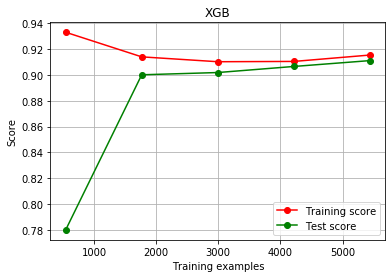

In [34]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100,random_state=420)
                   ,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

[15:04:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

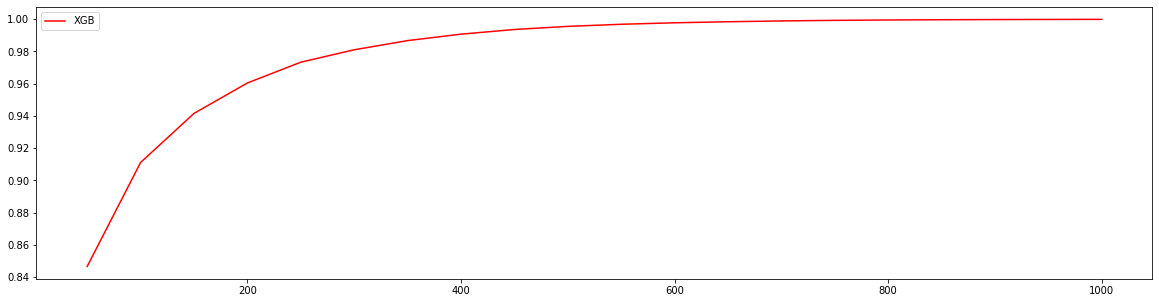

In [35]:
# 寻找合适的n_estimators
axisx = range(50,1050,50)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2+cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

In [36]:
#n_estimators取1000在进行一次测试
reg = XGBR(n_estimators=1000,random_state=420)
CVS(reg,Xtrain,Ytrain,cv=5).mean()

[15:08:19] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:23] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:27] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:30] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9998401644829743

[15:08:39] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:39] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:44] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:47] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:52] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:52] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

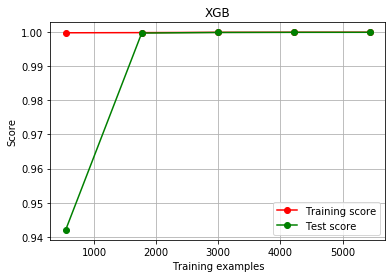

In [37]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=1000,random_state=420)
                   ,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

[15:09:39] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:42] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:43] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:44] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:44] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

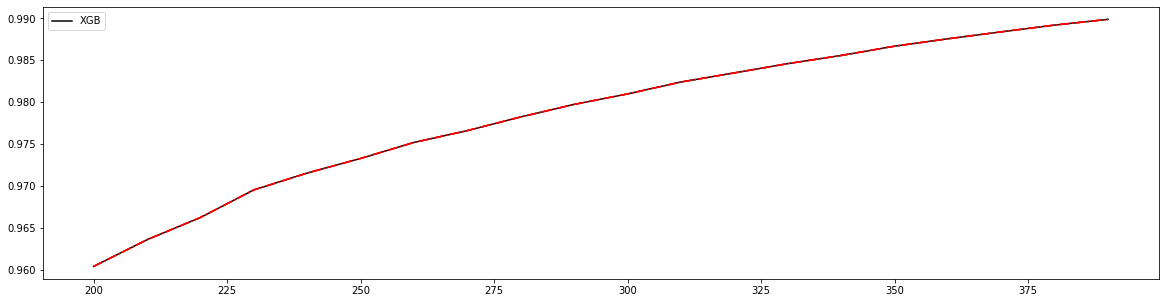

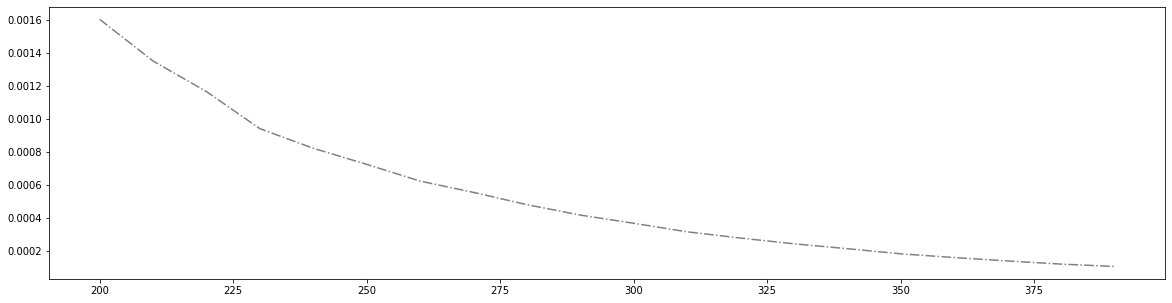

In [38]:
#细化学习曲线,根据之前的学习曲线重新测试一下
axisx = range(200,400,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#看看泛化误差的可控部分如何？
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle='-.')
plt.show()

In [39]:
# 用200重新测试一下
reg = XGBR(n_estimators=200,random_state=420)
CVS(reg,Xtrain,Ytrain,cv=5).mean()

[15:11:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:42] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:43] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:44] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9616856792737785

[15:11:45] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:45] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:45] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:46] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:46] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:47] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:47] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

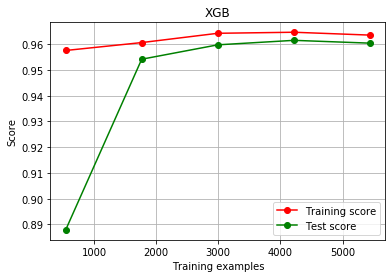

In [40]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=200,random_state=420)
                   ,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

[15:11:56] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:57] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:57] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:58] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:58] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:58] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:59] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

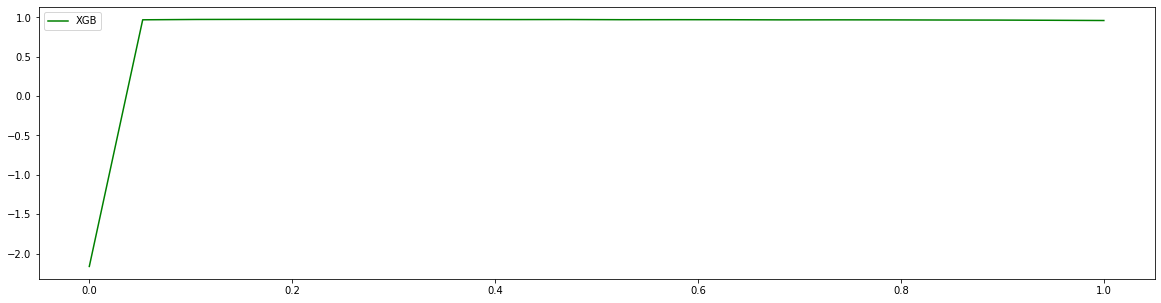

In [41]:
#寻找合适的subsample解决一下过拟合问题
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=200,subsample=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

[15:13:32] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:32] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:33] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:34] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:35] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

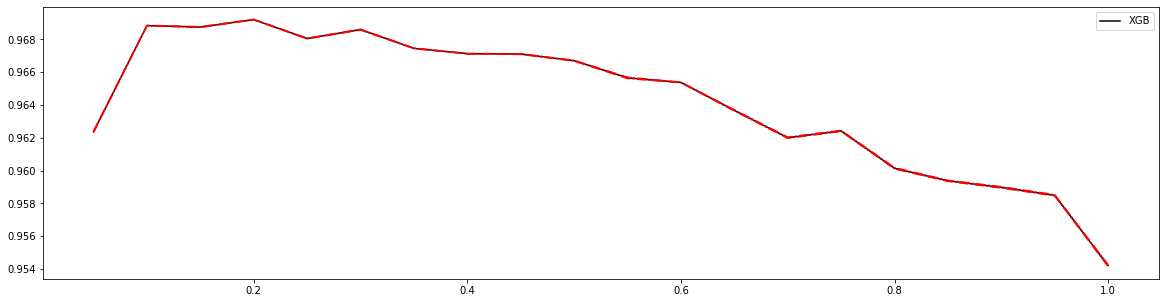

In [42]:
# 继续细化曲线
axisx = np.linspace(0.05,1,20)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=180,subsample=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

In [43]:
reg = XGBR(n_estimators=200
           ,subsample=0.2
           ,random_state=420).fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)

[15:15:02] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9781823608174333

In [44]:
import matplotlib as mpl

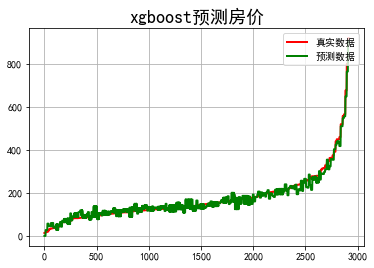

In [45]:
order = Ytest.sort_values().index
Ytest = Ytest.loc[order]
Xtest = Xtest.loc[order]
Ypredict = reg.predict(Xtest)
t = np.arange(len(Xtest))
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(facecolor='w')
plt.plot(t, Ytest, 'r-', linewidth=2, label=u'真实数据')
plt.plot(t, Ypredict, 'g-', linewidth=2, label=u'预测数据')
plt.title(u'xgboost预测房价', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()